# San Diego River Flow Rates at Fashion Valley

One problem with connecting the stream flow of the San Diego river to beach pollution is that the river flows through Dog beach, which is littered with dog feces. It's quite possible the station closest to the moth of the river, `PL-0100` is more correlated with the tides than with the river flow. 


In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np

In [2]:
pkg = mp.open_package('http://library.metatab.org/waterservices.usgs.gov-stream_discharge-fashion_valley_sd-1.csv')

In [3]:
pkg

In [4]:
pkg.resource('fashion_valley')

Header,Type,Description
agency_cd,string,Source agency. Always “USGS”
site_no,integer,"Site number, always “11023000”"
datetime,date,"Reading date, in ISO format."
discharge_rate,number,"Mean discharge, in cubic feet per second ( USGS Parameter 7745_00060_00003 )"
qualification_code,string,"A=Approved, e= Estimated, P=Provisional"


In [5]:
df = pkg.resource('fashion_valley').read_csv(parse_dates=True)

In [6]:
df.head()

,agency_cd,site_no,datetime,discharge_rate,qualification_code
0,USGS,11023000,1988-01-01,22.0,A
1,USGS,11023000,1988-01-02,20.0,A
2,USGS,11023000,1988-01-03,18.0,A
3,USGS,11023000,1988-01-04,18.0,A
4,USGS,11023000,1988-01-05,21.0,A


In [7]:
df = df[['datetime', 'discharge_rate']].copy().set_index('datetime')
df.head()

,discharge_rate
datetime,
1988-01-01,22.0
1988-01-02,20.0
1988-01-03,18.0
1988-01-04,18.0
1988-01-05,21.0


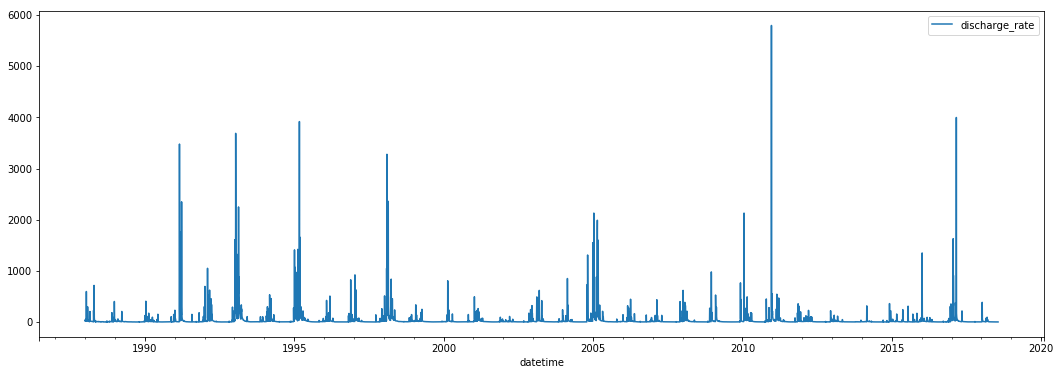

In [8]:
fig, ax = plt.subplots(1,figsize=(18,6))
df.plot(ax=ax)

In [9]:
bw_pkg = mp.open_package('http://library.metatab.org/ceden.waterboards.ca.gov-beachwatch-sandiego-2.zip')
bw_pkg

In [10]:
bw_df = bw_pkg.resource('beachwatch-sd').read_csv()
# It looks like the prefix of the station code groups stations, maybe into watersheds. 
bw_df['stationgroup'] = bw_df.stationcode.str[:2]

In [11]:
bw_stations = bw_df[['stationname','stationcode','stationgroup','targetlongitude','targetlatitude']].drop_duplicates()


In [12]:
## Load a Metapack data package of the US Counties, then extract San Diego county by it's FIPS code, state=6
## county=73 
counties_pkg = mp.open_package('http://library.metatab.org/census.gov-counties-2017-2.csv')

# Use the Metapack feature for turning the Pandas dataframe into a GeoPandas dataframe
counties = counties_pkg.resource('counties').geoframe()

sd_county = counties[(counties.statefp==6) & (counties.countyfp==73) ]

In [13]:
import folium


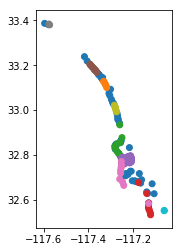

In [14]:
from shapely.geometry import Point
import geopandas as gpd


## Create a new GeoPandas frame, converting the targetlongitude and targetlatitude
## colums to a Shapely Point and assigning it to the frame's geometry

gdf = gpd.GeoDataFrame(bw_stations, geometry=
                        [Point(x,y) for x,y in zip(bw_stations.targetlongitude, bw_stations.targetlatitude)])

# Here is a quick plot
gdf.plot(column='stationgroup')

In [15]:

import folium

center = [32.755, -117.253] # Approx Dog Beach


m = folium.Map(location=center, zoom_start=13, control_scale=True)

for idx, row in bw_stations.iterrows():
    if row.stationcode.startswith("PL"):
        
        folium.Marker(location=[row.targetlatitude, row.targetlongitude],
                          icon=folium.DivIcon(
                            icon_size=(250,36),
                            icon_anchor=(0,0),
                            html='<div style="font-size: 10pt">{}</div>'.format(row.stationname),
                            )
                     ).add_to(m)
        folium.Marker(location=[row.targetlatitude, row.targetlongitude], popup=row.stationname).add_to(m)
    
m.save('pl_stations.html')
m